In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('NYData/AB_NYC_2019.csv')

# Introduction to CRISP-DM
In this notebook I will investigate my own business problem using CRISP-DM. 
The problem I chosed is: According to 2019 AirBnB NYC Dataset how can I efficently choose an accommodation in NYC?
I use CRISP-DM for evaluation my business problem. CRISP-DM follows distinctive steps:
- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results
  
Data Modeling is out of scope for my problem, since I am not interested in predicting new accommodations.


### Business Understanding

Let's start with the number of data points the Kaggle dataset contains

In [79]:
df.shape

(48895, 16)

Good almost 50,000 rows are enough to investigate the dataset. What is a little bit concerning is the low number of columns in the dataset. Let's what we have:

In [80]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


It is actually a little bit disappointing that now review score is contained in the dataset, but at least we can use some of the columns to investigate what features do drive the price the most.
I propose the following questions:
- Could it be that the minimum number of reviews have an effect on the price? Can I save money if I look for an accommodation in the same class but has less reviews?
- Do hosts want more money for their accommodations if they offer more accommodations 
- What about the location of the accommodation and it's type? Can I save money if I choose a less popular room type and a less popular neighbourhood? How much does it affect the price?

Let us first start with understanding and cleaning the data

In [81]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


First it is crazy to see that highest price is 10,000 whilst the dataset has a mean price of mean. Let's see how many max price accommodations the dataset contains and what features describe them:

In [82]:
df_luxury = df[df.price == 10000]
print(df_luxury.shape)
df_luxury.head()


(3, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
9151,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,2016-02-13,0.04,1,0
17692,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Erin,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.16,1,0
29238,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,NaN,1,83


In [83]:
df_budget = df[df.price == 0]
print(df_budget.shape)
print(df_budget.name.to_list)

(11, 16)
<bound method IndexOpsMixin.tolist of 23161    Huge Brooklyn Brownstone Living, Close to it all.
25433        ★Hostel Style Room | Ideal Traveling Buddies★
25634      MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)
25753                      Sunny, Quiet Room in Greenpoint
25778        Modern apartment in the heart of Williamsburg
25794    Spacious comfortable master bedroom with nice ...
25795    Contemporary bedroom in brownstone with nice view
25796         Cozy yet spacious private brownstone bedroom
26259                                the best you can find
26841    Coliving in Brooklyn! Modern design / Shared room
26866               Best Coliving space ever! Shared room.
Name: name, dtype: object>


It can be seen that there are Accommodations with zero price. I leave them our for the following analysis.

In [84]:
df = df[df.price != 0]

### Question 1: How is the price related to the number of reviews

Let's simply plot price against number of reviews and see what we get.

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

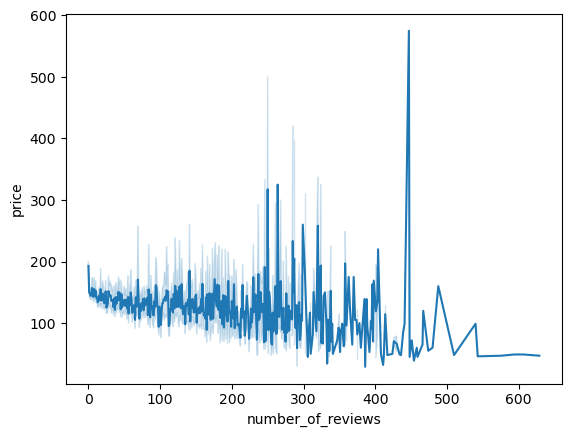

In [85]:
sns.lineplot(df, x="number_of_reviews", y="price")

It can be seen that the variance of price indeed increases with the number if reviews. So my conclusion is that it would make seens to also look for accommodations with less reviews and the same class/type of accommodation since one can save money by doing so.

### Question 2: Does the price increase if the host offers multiple accommodations?

First I group the data by host listings and then visualize the output using a line plot.

In [86]:
mean_price_per_host_listings = df.groupby(['calculated_host_listings_count']).price.mean()

In [87]:
mean_price_per_host_listings.sort_values()
df_host_listing = pd.DataFrame({'host listings': mean_price_per_host_listings.index,
                                'mean price': mean_price_per_host_listings.values})

In [91]:
df_host_listing.head()
df_host_listing_thres = df_host_listing[df_host_listing["host listings"] < 60]

<AxesSubplot:xlabel='host listings', ylabel='mean price'>

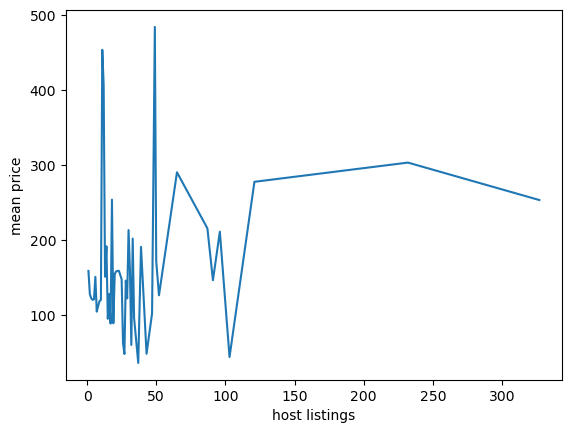

In [89]:
sns.lineplot(df_host_listing, y="mean price", x="host listings")

<AxesSubplot:xlabel='host listings', ylabel='mean price'>

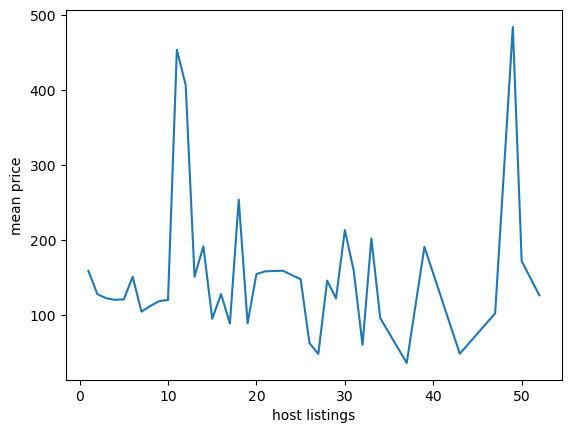

In [92]:
sns.lineplot(df_host_listing_thres, y="mean price", x="host listings")

If we take a look at the second plot it can be seen that the price is not correlated with the number of listings a host has. So you can also book an AirBnb without worrying about the number of listing the host has.

### Question 3: Which location in NYC should I choose for a certain room type?

Again we can answer the question by using pandas groupby function. This time I group by 'room_type' and 'neighbourhood_group'

In [93]:
room_type=df.groupby(['room_type', 'neighbourhood_group']).price.mean()

Below it is already pretty obvious that over all room types Manhattan is the most expensive location for your AirBnB. I use also a bar plot to investigate the data.

In [67]:
room_type.sort_values(ascending=False)

room_type        neighbourhood_group
Entire home/apt  Manhattan              249.257994
                 Brooklyn               178.346202
                 Staten Island          173.846591
                 Queens                 147.050573
                 Bronx                  127.506596
Private room     Manhattan              116.776622
Shared room      Manhattan               88.977083
Private room     Brooklyn                76.545428
                 Queens                  71.762456
Shared room      Queens                  69.020202
Private room     Bronx                   66.890937
                 Staten Island           62.292553
Shared room      Bronx                   59.800000
                 Staten Island           57.444444
                 Brooklyn                50.773723
Name: price, dtype: float64

<AxesSubplot:ylabel='room_type'>

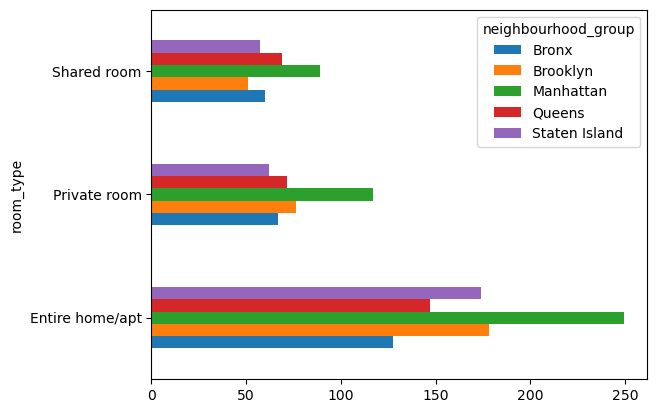

In [68]:
room_type.unstack().plot.barh()

Manhattan is without any doubt the most expensive place to live in NYC. If you want to save real money then at least a private room in Bornx but even more a shared room in Brooklyn is the right place for you. Instead of having an entire apartement in Manhattan one in Queens could be a real alternative!

### Evaluation
In my opinion the findings above are in general what one would expect from AirBnB Data e.g.:
- Manhattan is the most expansive location to live. The Bronx is the cheapest.
- Number of listings of a host do have noting to do with the price of an accommodation.
But what was surprising for me is that:
- The numbers of reviews correlate with the price
- The amount one can save if going for a entire apartment in Queens or Bronx instead of Manhattan.

So next time if I look for an AirBnb I will definitely also look for accommodations with less reviews!

## Prediction (out of curiosity)

In [94]:
# Get rid of NAN prices
df_pred = df.copy()
df_pred = df_pred.dropna(subset=['price'], axis=0)
# Drop names and id since they can't be used in below approach
df_pred = df_pred.drop(['name', 'host_name', 'id'], axis=1)

y = df_pred['price']

# Fill numerical NANs with mean
num_vars = df_pred.select_dtypes(include=['int','float'])
for num in num_vars.columns:
    df_pred[num].fillna((df_pred[num].mean()), inplace=True)

# alternative flow with lambda for learning purposes. I find it easier to directly us df_pred instead of using concat 
# after lambda has been applied
fill_mean = lambda col: col.fillna(col.mean(), inplace=True)
num_vars_mean = num_vars.apply(fill_mean, axis=0)
num_vars_mean.head()
# Onehot encoding for cat vars
cat_vars = df_pred.select_dtypes(include=['object']).copy().columns

for cat in cat_vars:
        df_pred = pd.concat([df_pred.drop(cat,axis=1), pd.get_dummies(df_pred[cat], prefix=cat, prefix_sep='_', drop_first=True)], axis=1)

X = df_pred

lm_model = Ridge()
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20) 

lm_model.fit(X_train, y_train)
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

print("The train r-squared score for the model was {} on {} values.".format(r2_score(y_train, y_train_preds), len(y_train)))
print("The test r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))



/Users/em07od/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.96015e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


The train r-squared score for the model was 1.0 on 39107 values.
The test r-squared score for the model was 1.0 on 9777 values.
